# Comparing diferent machine learning techniques to predict football results
# - Authors and affiliations
### Abstract

# 1. Introduction

As one of the most popular sports on the planet, football has always been followed
very closely by a large number of people. In recent years, new types of data have
been collected for many games in various countries, such as play-by-play data including information on each shot or pass made in a match.

Information like this can be found in datasets like [the Football Events dataset](https://datasetsearch.research.google.com/search?docid=beC2NjeMuiLj9GvLAAAAAA%3D%3D) found on kaggle.

This projects objective is to use the above mentioned dataset to predict the number of goals on a football game using Regression algorithms.
This paper will start with an explanation and analysis of the used dataset, followed by an explanation of the approach the was decided to be used.

Tests will be performed on the developed models and explanation for the results will be given at the end.

# 2. Description of the problem/dataset

Our data set has two files of data and one dictionary. The first file (events.csv) gives information on all the
recorded events with 941,009 events for 9,074 games. The second file (ginf.csv) gives the details of the
odds for the games recorded in the first file . for each league we have information on the seasons
from 2012 to 2017 except the English league which information only starts in the season 2014.
The dictionary helps us to understands the values in some of the columns of the events table.

We will focus more on the first table which will be the most useful since we not using odds.

## 2.1. events.csv Columns

1. id odsp : Unique identifier of the game (odsp stands from oddsportal.com)
2. id event : Unique identifier of event (id odsp + sort order)
3. sort order : Chronological sequence of events in a game
4. time : Minute of the game when the event happened
5. text : Text commentary
6. event type : Primary event. 11 unique events (1-Attempt(shot), 2-Corner, 3-Foul, 4-Yellow Card, 5-Second Yellow Card, 6-(Straight) Red Card, 7-Substitution, 8-Free Kick Won, 9-Offside, 10-Hand Ball, 11-Penalty conceded)
7. event type2 : Cecondary event. 4 unique events (12 - Key Pass, 13 - Failed through ball, 14-Sending off, 15-Own goal)
8. side : 1-Home, 2-Away
9. event team : Team that produced the event. In case of Own goals, event team is the team that benefited from the own goal
10. opponent : Team that the event happened against
11. player : Name of the player involved in main event (converted to lowercase and special
chars were removed)
12. player2 : Name of player involved in secondary event 8
13. player in : Player that came in (only applies to substitutions)
14. player out : Player substituted (only applies to substitutions)
15. shot place : Placement of the shot (13 possible placement locations, available in the
dictionary, only applies to shots)
16. shot outcome : 4 possible outcomes (1-On target, 2-Off target, 3-Blocked, 4-Hit the post)
17. is goal : Binary variable if the shot resulted in a goal (own goals included)
18. location : Location on the pitch where the event happened (19 possible locations, available
in the dictionary)
19. bodypart : (1- right foot, 2-left foot, 3-head)
20. assist method : In case of an assisted shot, 5 possible assist methods (details in the dictionary)
21. situation : 4 types: 1-Open Play, 2-Set piece (excluding Direct Free kicks), 3-Corner, 4-Free kick

## 2.2 Loading the Data

In [7]:
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import seaborn as sb

From the website we also know that the missing values are set as 'NA'so we should treat them as such

In [8]:
events = pd.read_csv('football-events/events.csv',na_values=['NA'])
games = pd.read_csv('football-events/ginf.csv',na_values=['NA'])

In [3]:
events.describe()

,sort_order,time,event_type,event_type2,side,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
count,941009.000000,941009.000000,941009.000000,214293.000000,941009.000000,227459.000000,228498.000000,941009.000000,467067.000000,229185.000000,941009.000000,229137.000000,941009.000000
mean,53.858826,49.663663,4.326575,12.233764,1.481170,5.733693,1.926555,0.025978,6.209073,1.624831,0.264332,1.281316,0.004876
std,32.014268,26.488977,2.995313,0.468850,0.499646,3.326100,0.797055,0.159071,5.421736,0.740400,0.655501,0.709394,0.069655
min,1.000000,0.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,27.000000,27.000000,2.000000,12.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000
50%,53.000000,51.000000,3.000000,12.000000,1.000000,5.000000,2.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,79.000000,73.000000,8.000000,12.000000,2.000000,9.000000,3.000000,0.000000,11.000000,2.000000,0.000000,1.000000,0.000000
max,180.000000,100.000000,11.000000,15.000000,2.000000,13.000000,4.000000,1.000000,19.000000,3.000000,4.000000,4.000000,1.000000


We might be dealing with events that dont have a corresponding game in the ```ginf.csv``` table. So let's verify that first.

We can check if there are any 'rogue events' by joining both tables on the game id and checking if there is any loss of rows.  

In [4]:
unique_games = games['id_odsp'].nunique()
unique_documented_games = events['id_odsp'].nunique()
event_number = events['id_odsp'].size
print(f'Number of events = {event_number}')
merged_size = pd.merge(events, games, right_on='id_odsp', left_on='id_odsp', how='inner')['id_odsp'].size
print(f'Number of events after merge = {merged_size}')

Number of events = 941009
Number of events after merge = 941009


Since there were no lost events after the merge, we can rest assured that there are no rogue events in this dataset.

The dataset's website also states that only around 90% of the games in ```ginf.csv``` have events in ```events.csv```.

In [11]:
print(f'{unique_games} unique games.')
print(f'{unique_documented_games} unique documented games.')
print(f'{unique_games - unique_documented_games} unique undocumented games.')
print(f'{unique_documented_games/unique_games * 100:.2f}% of games are documented.')

10112 unique games.
9074 unique documented games.
1038 unique undocumented games.
89.73% of games are documented.


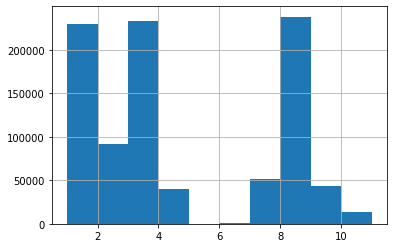

In [24]:
differences = events.iloc[:,5]
differences.hist()

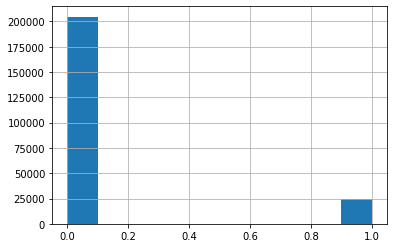

In [22]:
shots = events[(events.event_type==1)]

shots['is_goal'].hist()

/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/paulo/.local/lib/python3.7/site-packages/seaborn/distributions.p

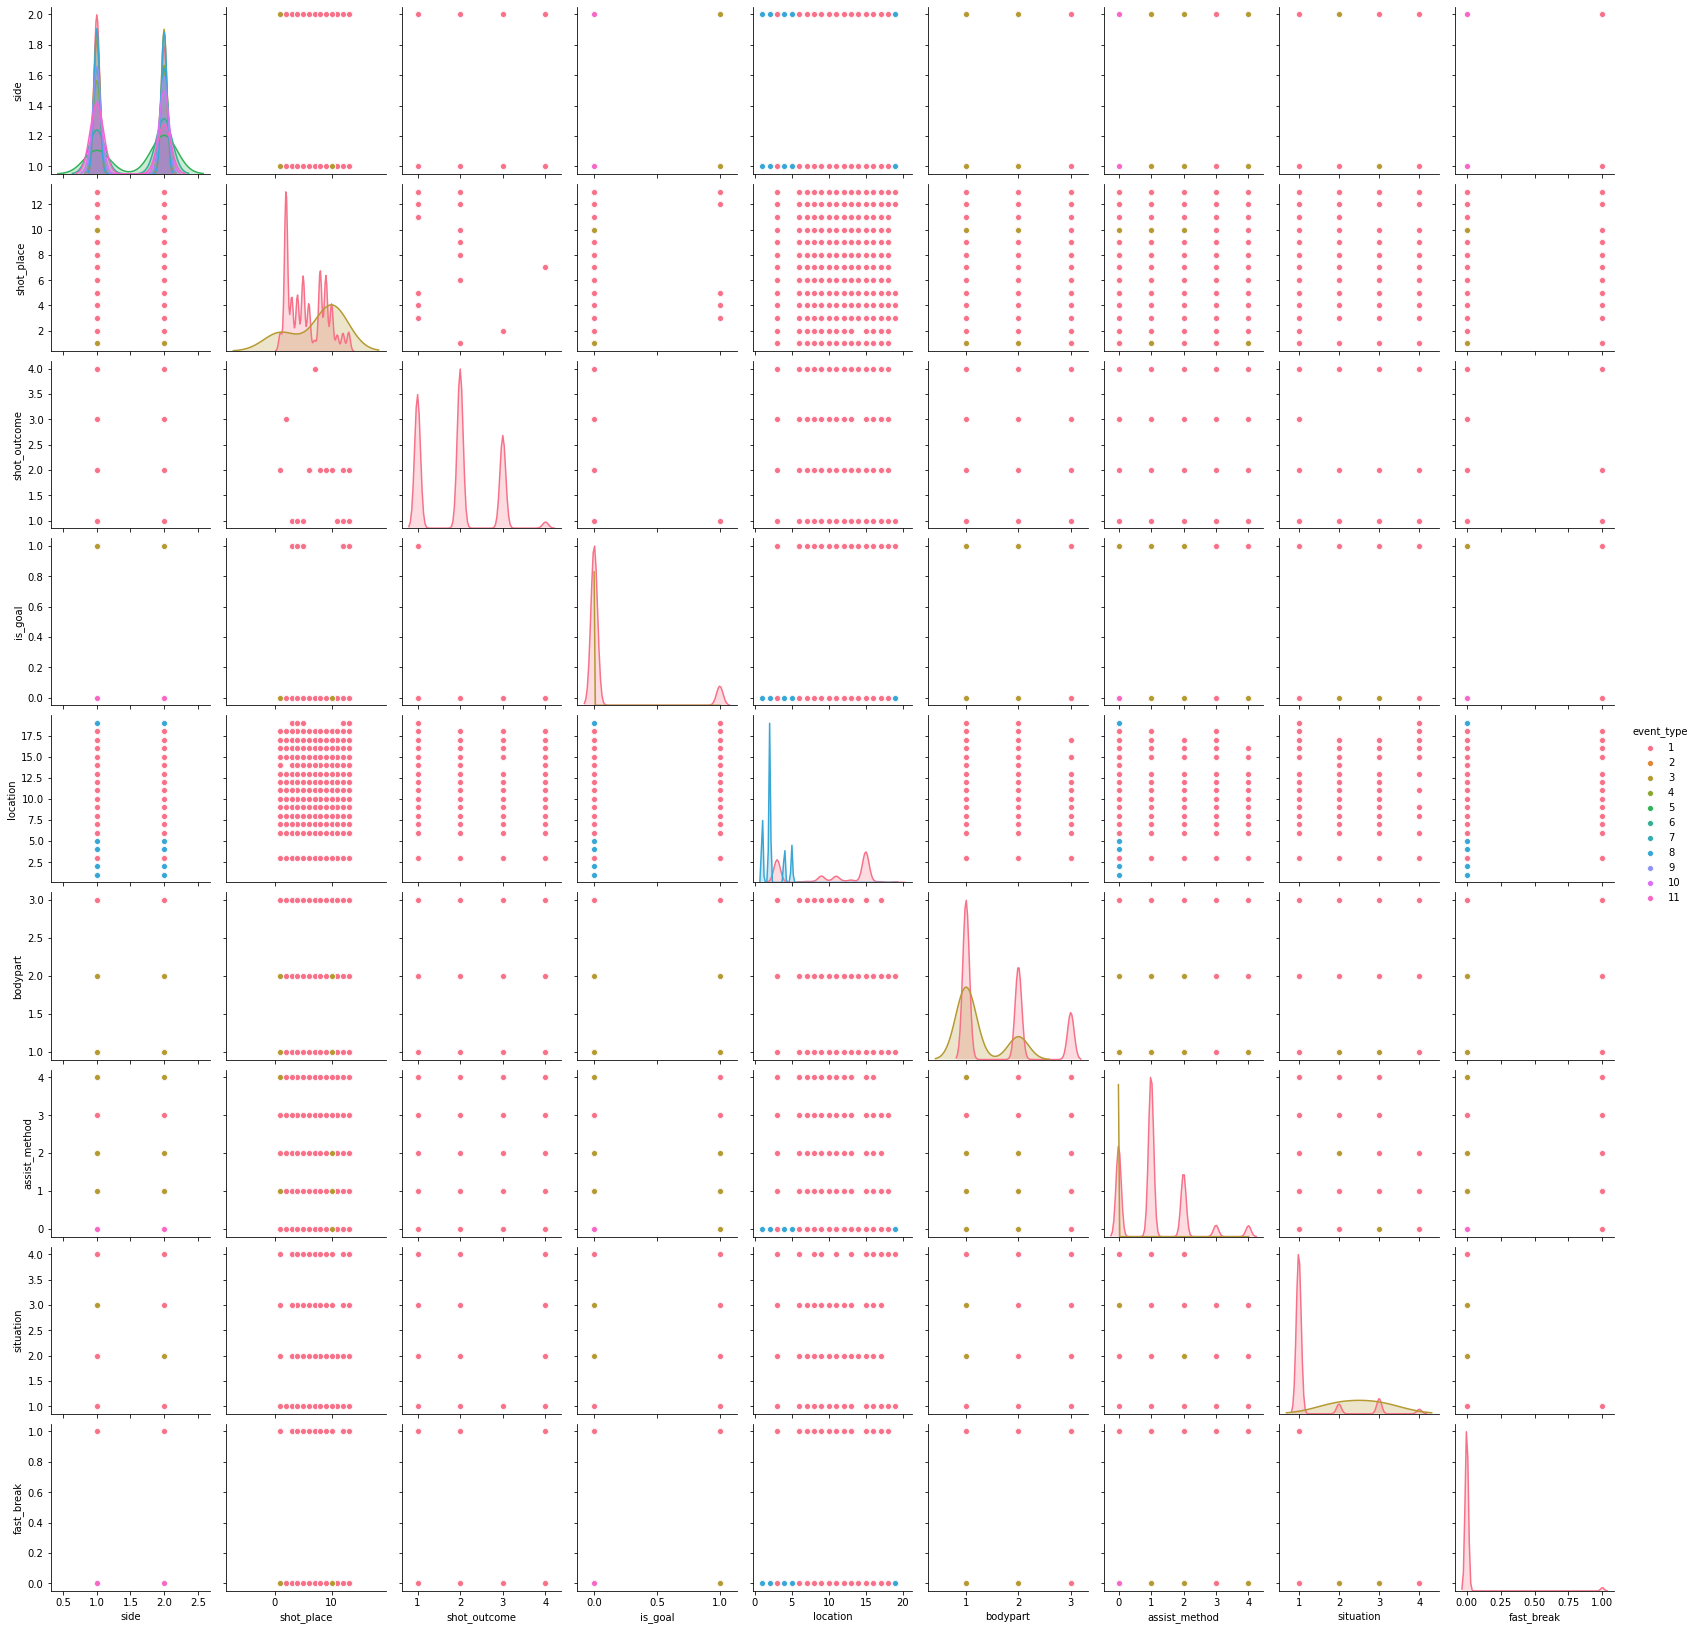

In [26]:
sb.pairplot(events.drop(['id_odsp','id_event','sort_order','time','text','event_type2','event_team','opponent','player_in','player_out'],axis=1), hue='event_type')

# 3. Approach
Inserir descrição do modelo

In [14]:
#Useful imports
import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
import scipy as sp
import seaborn as sb
import sklearn
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error, mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In our model we want to predict the number of goals by a team in a match, therefore, the depedent variable is the number of goals by a team


## 3.1. Preparing the data

### 3.1.1 The xG Classifier

In [15]:
shots = events[(events.event_type==1)]
shots_prediction = shots.iloc[:,-6:]
dummies = pd.get_dummies(shots_prediction, columns=['location', 'bodypart','assist_method', 'situation'])
dummies.columns = ['is_goal', 'fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right', 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range', 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header', 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']

In [16]:
X = dummies.iloc[:,1:]
y = dummies.iloc[:,0]

In [17]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(28, 28, 28, 28), max_iter=2000, activation='relu')
mlp.fit(X_train, y_train)

CPU times: user 26.8 s, sys: 0 ns, total: 26.8 s
Wall time: 26.8 s


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(28, 28, 28, 28), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [18]:
predict = mlp.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test,predict))
print('Report:')
print(classification_report(y_test,predict))
accuracy = mlp.score(X_test, y_test)
print('The accuracy of classifying whether a shot is goal or not is {:.2f} %.'.format(accuracy*100))

Confusion Matrix:
[[70771   923]
 [ 6214  2290]]
Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198

The accuracy of classifying whether a shot is goal or not is 91.10 %.


### 3.1.2. Analysing the xG classifier

Unbalanced number of sample, way more missed shots than goals

### 3.1.3. Assembling everything

In [29]:
dummies['xG'] = mlp.predict_proba(X)[:,1]
dummies = dummies[['xG']].copy()
dataWithXG = shots.join(dummies[['xG']])
matchXG = dataWithXG.groupby(['id_odsp', 'side'])['xG'].sum().reset_index()

In [30]:
# Number of shots
attempts = events[(events.event_type==1)]
shotsSorted = attempts.groupby(['id_odsp', 'side']).count().reset_index()
shotsClean = shotsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"shot_count"})

# Number of corners
corners = events[(events.event_type==2)]
cornersSorted = corners.groupby(['id_odsp', 'side']).count().reset_index()
cornersClean = cornersSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"corner_count"})

# Number of fouls
fouls = events[(events.event_type==3)]
foulsSorted = fouls.groupby(['id_odsp', 'side']).count().reset_index()
foulsClean = foulsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"foul_count"})

# Number of yellow cards
yellow_cards = events[(events.event_type==4)]
ycSorted = yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
ycClean = ycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"yellow_card_count"})

# Number of second yellow cards
second_yellow_cards= events[(events.event_type==5)]
sycSorted = second_yellow_cards.groupby(['id_odsp', 'side']).count().reset_index()
sycClean = sycSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"second_yellow_card_count"})

# Number of red cards
red_cards = events[(events.event_type==6)]
redCardsSorted = red_cards.groupby(['id_odsp', 'side']).count().reset_index()
redCardsClean = redCardsSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"red_card_count"})

# Number of freekicks
free_kicks = events[(events.event_type==8)]
fkSorted = free_kicks.groupby(['id_odsp', 'side']).count().reset_index()
fkClean = fkSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"free_kick_count"})

# Number of offsides
offsides = events[(events.event_type==9)].copy()
offsidesSorted = offsides.groupby(['id_odsp', 'side']).count().reset_index()
offsidesClean = offsidesSorted[['id_odsp', 'side', 'id_event']].rename(columns={"id_event":"offside_count"})



In [31]:
#Joins results
joinColumns = ['id_odsp', 'side']

fullDataset = matchXG

fullDataset = fullDataset.merge(shotsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(cornersClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(ycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(sycClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(redCardsClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(fkClean, on=joinColumns, how='left') 
fullDataset = fullDataset.merge(offsidesClean, on=joinColumns, how='left') 
fullDataset= fullDataset.merge(events[['id_odsp', 'side', 'event_team']].drop_duplicates(), on=joinColumns, how='left')
fullDataset = fullDataset.fillna(0)

for column in fullDataset.columns:
    if column.endswith('_count'):
        fullDataset[column] = fullDataset[column].astype(int)





In [32]:
homeGoals = games[['id_odsp', 'fthg']].rename(columns={'fthg':'goals'})
homeGoals.insert(2, 'side', 1)
awayGoals = games[['id_odsp', 'ftag']].rename(columns={'ftag':'goals'})
awayGoals.insert(2, 'side', 2)
totalGoals = homeGoals.append(awayGoals)
fullDataset = fullDataset.merge(totalGoals, on=joinColumns, how='left')

In [33]:
fullDataset['other_side'] = fullDataset['side'].apply(lambda x: 2 if x == 1 else 1)

In [34]:
teamNames = fullDataset[['id_odsp', 'event_team', 'side']].rename(columns={'event_team':'other_event_team', 'side':'other_side'})
fullDataset = fullDataset.merge(teamNames, on=['id_odsp', 'other_side'], how='left').drop(columns=['other_side'])

In [35]:
fullDataset

,id_odsp,side,xG,shot_count,corner_count,yellow_card_count,second_yellow_card_count,red_card_count,free_kick_count,offside_count,event_team,goals,other_event_team
0,004f4ING/,1,1.413347,15,9,1,0,1,8,0,Southampton,0,Swansea
1,004f4ING/,2,0.453106,6,0,1,0,0,10,3,Swansea,1,Southampton
2,00LMl81F/,1,2.949324,24,13,2,0,0,14,0,AS Roma,2,AC Milan
3,00LMl81F/,2,1.608309,15,4,3,0,1,10,6,AC Milan,3,AS Roma
4,00OX4xFp/,1,1.166929,9,4,1,0,0,18,3,AS Monaco,0,Lille
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18139,zyKwAQxf/,2,1.218277,13,3,2,0,0,9,2,Malaga,0,Celta Vigo
18140,zyrHmI8P/,1,2.183775,9,6,1,0,0,7,1,Valencia,4,Eibar
18141,zyrHmI8P/,2,1.008775,9,3,2,0,0,11,3,Eibar,0,Valencia
18142,zyzdxP10/,1,1.587103,13,3,1,0,0,12,3,Levante,2,Real Madrid


## 3.2 Algorithms

In [25]:
# for calculating F2 adjusted
def adjusted_r2(r2, mod):
    return (1 - (1 - r2) * ((mod.shape[0] - 1) / 
          (mod.shape[0] - mod.shape[1] - 1)))

### 3.2.1 Decision Tree

In [26]:
%%time
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['event_team', 'other_event_team']), fullY, test_size=0.35, random_state=1)
decTree = tree.DecisionTreeRegressor(max_depth=5)
decTree.fit(fullXTrain, fullYTrain)


predict = decTree.predict(fullXTest)
r2 = decTree.score(fullXTest, fullYTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'{r2=} {adjR2=} {absErr=} {sqErr=}')

SyntaxError: invalid syntax (<fstring>, line 1)

### 3.2.2 Random Forest

In [ ]:
%%time
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['event_team', 'other_event_team']), fullY, test_size=0.35, random_state=1)
randForest = RandomForestRegressor(max_depth=5)
randForest.fit(fullXTrain, fullYTrain)


predict = randForest.predict(fullXTest)
r2 = randForest.score(fullXTest, fullYTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'{r2=} {adjR2=} {absErr=} {sqErr=}')

### 3.2.3 Support vector machine

In [ ]:
%%time
from sklearn import svm
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['other_event_team','event_team']), fullY, test_size=0.35, random_state=1)
svm = svm.LinearSVR(max_iter=40000)
svm.fit(fullXTrain, fullYTrain)


predict = svm.predict(fullXTest)
r2 = svm.score(fullXTest, fullYTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'{r2=} {adjR2=} {absErr=} {sqErr=}')

### 3.2.4 Neural Network (Multiple layer perceptron)

In [ ]:
%%time
fullXTrain, fullXTest, fullYTrain, fullYTest = train_test_split(fullX.drop(columns=['other_event_team','event_team']), fullY, test_size=0.35, random_state=1)
mlpReg = MLPRegressor()
mlpReg.fit(fullXTrain, fullYTrain)


predict = mlpReg.predict(fullXTest)
r2 = mlpReg.score(fullXTest, fullYTest)
absErr = mean_absolute_error(fullYTest,predict)
sqErr = mean_squared_error(fullYTest,predict)
adjR2 = adjusted_r2(r2, fullXTest)

print(f'{r2=} {adjR2=} {absErr=} {sqErr=}')

## 3.3 Added depedent variables - FALAR AQUI DAS TAGS DAS EQUIPAS

# 4. Evaluation

# 5. Conclusions

The data set, and inherently the model, are flawed.
In essence, football games present an extremelly non deterministic world. 
The number of goals a team scores doesn't depend only on the recorded statistics, it also depends on player health, team state of mind, factors that are foreign to the games like club internall conflicts, etc.

This leads to situations were two games of a team that have exactly the same statistics will have different results, due to the circumstances of that time. 
It also makes it hard to find outliers as we can't choose which behaviour is normal.
All of this added together makes regression models have a hard time being accurate.

Another problem is that the dataset holds is missing some data that would be extremelly useful, like ball possession percentages.

### References